# The Stanford Sentiment Treebank 
The Stanford Sentiment Treebank consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [4]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

In [5]:
import tensorflow as tf
import tensorflow_datasets

from tensorflow.keras.utils import to_categorical

from transformers import (
    BertConfig,
    BertTokenizer,
    XLMRobertaTokenizer,
    TFBertModel,
    TFXLMRobertaModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors
)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from google.cloud import storage

import math
import numpy as np
import os
import glob
import time
from datetime import timedelta
import shutil
from datetime import datetime
import pickle
import re

## Check configuration

In [6]:
print(tf.version.GIT_VERSION, tf.version.VERSION)

v2.2.0-rc1-34-ge6e5d6df2a 2.2.0-rc2


In [7]:
print(tf.keras.__version__)

2.3.0-tf


In [8]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)>0:
    for gpu in gpus:
        print('Name:', gpu.name, '  Type:', gpu.device_type)
else:
    print('No GPU available !!!!')

No GPU available !!!!


## Define Paths

In [9]:
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')
try:   
    savemodel_dir=os.environ['PATH_SAVE_MODEL']
except KeyError:
    print('missing PATH_SAVE_MODEL')

## Import local packages

In [10]:
import preprocessing.preprocessing as pp
import utils.model_metrics as mm
import utils.model_utils as mu

/Users/tarrade/anaconda-release/conda-env/env_test/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
import importlib
importlib.reload(pp);
importlib.reload(mm);
importlib.reload(mu);

## Loading a data from Tensorflow Datasets

In [12]:
data, info = tensorflow_datasets.load(name='glue/sst2',
                                      data_dir=data_dir,
                                      with_info=True)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset glue (/Users/tarrade/tensorflow_datasets/glue/sst2/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /Users/tarrade/tensorflow_datasets/glue/sst2/1.0.0


### Checking baics info from the metadata

In [13]:
info

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.

            The Stanford Sentiment Treebank consists of sentences from movie reviews and
            human annotations of their sentiment. The task is to predict the sentiment of a
            given sentence. We use the two-way (positive/negative) class split, and use only
            sentence-level labels.',
    homepage='https://nlp.stanford.edu/sentiment/index.html',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=70042,
    splits={
        'test': 1821,
        'train': 67349,
        'validation': 872,
    },
    supervised_keys=None,
    citation="""@

In [14]:
pp.print_info_dataset(info)

Labels:
      ['negative', 'positive']

Number of label:
      2

Structure of the data:
      dict_keys(['sentence', 'label', 'idx'])

Number of entries:
   Train dataset: 67349
   Test dataset:  1821
   Valid dataset: 872



### Checking baics info from the metadata

In [15]:
data

{'test': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'train': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'validation': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>}

In [16]:
data.keys()

dict_keys(['test', 'train', 'validation'])

In [17]:
pp.print_info_data(data['train'])

# Structure of the data:

   <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

# Output shape of one entry:
   {'idx': TensorShape([]), 'label': TensorShape([]), 'sentence': TensorShape([])}

# Output types of one entry:
   {'idx': tf.int32, 'label': tf.int64, 'sentence': tf.string}

# Output typesof one entry:
   {'idx': <class 'tensorflow.python.framework.ops.Tensor'>, 'label': <class 'tensorflow.python.framework.ops.Tensor'>, 'sentence': <class 'tensorflow.python.framework.ops.Tensor'>}
 

# Shape of the data:

   (67349,)
   ---> 67349 entries
   ---> 1 dim
        dict structure
           dim: 3
           [idx       / label     / sentence ]
           [()        / ()        / ()       ]
           [int32     / int64     / bytes    ]


# Examples of data:
{'idx': 16399,
 'label': 0,
 'sentence': b'for the uninitiated plays better on video with the sound '}
{'idx': 1680,
 'label': 0,
 'sentence': b'like a g

## Define parameters of the model

In [18]:
# models
#MODELS = [(TFBertModel,     BertTokenizer,       'bert-base-multilingual-uncased'),
#          (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
#          (GPT2Model,       GPT2Tokenizer,       'gpt2'),
#          (CTRLModel,       CTRLTokenizer,       'ctrl'),
#          (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
#          (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
#          (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
#          (DistilBertModel, DistilBertTokenizer, 'distilbert-base-cased'),
#          (RobertaModel,    RobertaTokenizer,    'roberta-base'),
#          (XLMRobertaModel, XLMRobertaTokenizer, 'xlm-roberta-base'),
#         ]
MODELS = [(TFBertModel,         BertTokenizer,       'bert-base-multilingual-uncased'),
          (TFXLMRobertaModel,   XLMRobertaTokenizer, 'jplu/tf-xlm-roberta-base')]
model_index = 0 # BERT
model_class        = MODELS[model_index][0] # i.e TFBertModel
tokenizer_class    = MODELS[model_index][1] # i.e BertTokenizer
pretrained_weights = MODELS[model_index][2] #'i.e bert-base-multilingual-uncased'

# Maxium length, becarefull BERT max length is 512!
MAX_LENGTH = 128

# define parameters
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32
BATCH_SIZE_VALID = 64
EPOCH = 2

# extract parameters
size_train_dataset = info.splits['train'].num_examples
size_test_dataset = info.splits['test'].num_examples
size_valid_dataset = info.splits['validation'].num_examples
number_label = info.features["label"].num_classes

# computer parameter
STEP_EPOCH_TRAIN = math.ceil(size_train_dataset/BATCH_SIZE_TRAIN)
STEP_EPOCH_TEST = math.ceil(size_test_dataset/BATCH_SIZE_TEST)
STEP_EPOCH_VALID = math.ceil(size_test_dataset/BATCH_SIZE_VALID)


print('Dataset size:          {:6}/{:6}/{:6}'.format(size_train_dataset, size_test_dataset, size_valid_dataset))
print('Batch size:            {:6}/{:6}/{:6}'.format(BATCH_SIZE_TRAIN, BATCH_SIZE_TEST, BATCH_SIZE_VALID))
print('Step per epoch:        {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN, STEP_EPOCH_TEST, STEP_EPOCH_VALID))
print('Total number of batch: {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN*(EPOCH+1), STEP_EPOCH_TEST*(EPOCH+1), STEP_EPOCH_VALID*(EPOCH+1)))

Dataset size:           67349/  1821/   872
Batch size:                32/    32/    64
Step per epoch:          2105/    57/    29
Total number of batch:   6315/   171/    87


## Tokenizer and prepare data for BERT

In [19]:
# Define the checkpoint directory to store the checkpoints
pretrained_model_dir=savemodel_dir+'/pretrained_model/'+pretrained_weights
os.makedirs(pretrained_model_dir, exist_ok=True)

In [20]:
# Load tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, cache_dir=pretrained_model_dir)

In [21]:
# recap of input dataset
print(data['train'])
print(tf.data.experimental.cardinality(data['train']))
print(tf.data.experimental.cardinality(data['test']))
print(tf.data.experimental.cardinality(data['validation']))
# super slow since looping over all data
#print(len(list(data['train'])))

<DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>
tf.Tensor(67349, shape=(), dtype=int64)
tf.Tensor(1821, shape=(), dtype=int64)
tf.Tensor(872, shape=(), dtype=int64)


In [22]:
# Prepare data for BERT
train_dataset = glue_convert_examples_to_features(data['train'], 
                                                  tokenizer, 
                                                  max_length=MAX_LENGTH, 
                                                  task='sst-2')
test_dataset = glue_convert_examples_to_features(data['test'], 
                                                  tokenizer, 
                                                  max_length=MAX_LENGTH, 
                                                  task='sst-2')
valid_dataset = glue_convert_examples_to_features(data['validation'], 
                                                  tokenizer, 
                                                  max_length=MAX_LENGTH, 
                                                  task='sst-2')

In [23]:
# recap of pre processing dataset
print(train_dataset)
print(tf.data.experimental.cardinality(train_dataset))
print(tf.data.experimental.cardinality(test_dataset))
print(tf.data.experimental.cardinality(valid_dataset))
# super slow since looping over all data
print(len(list(train_dataset)))

<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)
67349


In [24]:
# set shuffle and batch size
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE_TRAIN).repeat(EPOCH+1)
test_dataset = test_dataset.shuffle(100).batch(BATCH_SIZE_TEST).repeat(EPOCH+1)
valid_dataset = valid_dataset.batch(BATCH_SIZE_VALID) #.repeat(EPOCH+1)

## Check the final data

In [25]:
pp.print_info_data(train_dataset,print_example=False)

# Structure of the data:

   <RepeatDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

# Output shape of one entry:
   ({'input_ids': TensorShape([None, None]), 'attention_mask': TensorShape([None, None]), 'token_type_ids': TensorShape([None, None])}, TensorShape([None]))

# Output types of one entry:
   ({'input_ids': tf.int32, 'attention_mask': tf.int32, 'token_type_ids': tf.int32}, tf.int64)

# Output typesof one entry:
   ({'input_ids': <class 'tensorflow.python.framework.ops.Tensor'>, 'attention_mask': <class 'tensorflow.python.framework.ops.Tensor'>, 'token_type_ids': <class 'tensorflow.python.framework.ops.Tensor'>}, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (6315, 2)
   ---> 6315 batches
   ---> 2 dim
        label
           shape: (32,)
        dict structure
           dim: 3
        

In [26]:
pp.print_detail_tokeniser(train_dataset, tokenizer)

 input_ids     ---->    attention_mask    token_type_ids    modified text                 

       101     ---->           1                 1          [ C L S ]                     
     10346     ---->           1                 1          b e                           
     12338     ---->           1                 1          s a i d                       
     10203     ---->           1                 1          t h a t                       
     10191     ---->           1                 1          h e                           
     10127     ---->           1                 1          i s                           
     10144     ---->           1                 1          a n                           
     13860     ---->           1                 1          i m a                         
     30831     ---->           1                 1          # # g i n a                   
     14279     ---->           1                 1          # # t i v e                  

## Building a classification model

### Use TFBertForSequenceClassification

In [27]:
# Define some parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_1 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_1.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_1.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_1 = TFBertForSequenceClassification.from_pretrained(pretrained_weights,num_labels=number_label, cache_dir=pretrained_model_dir)
    #model.layers[-1].activation = tf.keras.activations.softmax
    model_1._name='tf_bert_classification'
    model_1.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


In [28]:
model_1.summary()

Model: "tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


### Building a custom classification model 

In [29]:
def custom_keras_model(number_classes, bert_model, model_class):

    # create model
    input_layer = tf.keras.Input(shape = (128,), dtype='int64')    
    #bert_ini = TFBertModel.from_pretrained(bert_model, cache_dir=pretrained_model_dir) (input_layer)
    bert_ini = model_class.from_pretrained(bert_model, cache_dir=pretrained_model_dir) (input_layer)
    # This is because in a bert pretraining progress, there are two tasks: 
    # masked token prediction and next sentence predition . 
    # The first needs hidden state of each tokens ( shape: [batch_size, sequence_length, hidden_size]) 
    # the second needs the embedding of the whole sequence (shape : [batch_size, hidden_size] ) .
    bert = bert_ini[1]    
    dropout = tf.keras.layers.Dropout(0.1)(bert)
    flat = tf.keras.layers.Flatten()(dropout)
    classifier = tf.keras.layers.Dense(units=number_classes )(flat) # activation='softmax'               
    
    model = tf.keras.Model(inputs=input_layer, outputs=classifier, name='custom_tf_bert_classification')

    return model, bert_ini

In [30]:
# Define some parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_2 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_1.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_2.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_2, bert_ini = custom_keras_model(number_label, pretrained_weights, model_class)
    model_2.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


In [31]:
bert_ini[0]

<tf.Tensor 'tf_bert_model/Identity:0' shape=(None, 128, 768) dtype=float32>

In [32]:
bert_ini[1]

<tf.Tensor 'tf_bert_model/Identity_1:0' shape=(None, 768) dtype=float32>

In [33]:
model_2.summary()

Model: "custom_tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 128, 768), (None, 167356416 
_________________________________________________________________
dropout_75 (Dropout)         (None, 768)               0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


## Select the model for training

In [34]:
model=model_1
print('model\'s name: {}'.format(model.name))

model's name: tf_bert_classification


## Setup of the Callbacks

### TensorBoard

In [35]:
# checking existing folders
for i in os.listdir(tensorboard_dir):
    if os.path.isdir(tensorboard_dir+'/'+i):
        print(i)

20200410-184433


In [36]:
# clean old TensorBoard directory 
for i in os.listdir(tensorboard_dir):
        if os.path.isdir(tensorboard_dir+'/'+i):
            print('remiving:', i)
            shutil.rmtree(tensorboard_dir+'/'+i, ignore_errors=False)

remiving: 20200410-184433


In [37]:
# create a new directory
log_dir=tensorboard_dir+'/'+datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(log_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      embeddings_freq=1,
                                                      write_graph=True,
                                                      update_freq='batch',
                                                      profile_batch=1)

### Model Checkpoints

In [38]:
# Define the checkpoint directory to store the checkpoints
checkpoint_dir=savemodel_dir+'/checkpoint_model/'+model.name
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}') 
#checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}-{accuracy:.4f}')

In [39]:
# clean old checkpoints
for i in os.listdir(checkpoint_dir):
        if os.path.exists(checkpoint_dir+'/'+i):
            os.remove(checkpoint_dir+'/'+i)

In [40]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                         verbose=1,
                                                         save_weights_only=True)

#checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                                         monitor='accuracy',
#                                                         save_best_only=True,
#                                                         mode='max',
#                                                         save_freq=2,
#                                                         period=5,
#                                                         verbose=1,
#                                                         save_weights_only=True)

### Decaying learning rate

In [41]:
decay_callback = tf.keras.callbacks.LearningRateScheduler(mu.decay)

### Checks callbacks

In [42]:
list_callback = [tensorboard_callback, checkpoint_callback, decay_callback]
for cb in list_callback:
    if type(cb).__name__=='tuple':
        print(cb[0].__class__.__name__, 'need to unpack this tuple by adding *')

Maybe some callback need to unpack this tuple by adding *

## TensorBoard

In [43]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard  --logdir   {log_dir} \
              #--port 6667 \
              #--debugger_port 6667

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Training

In [44]:
# input format depending of the type of model
def data_feature_extraction(data, name):
    if name=='custom_tf_bert_classification':
        print('custom model: {}'.format(name))
        return data.map(pp.feature_selection)
    elif name=='tf_bert_classification':
        print('standard model: {}'.format(name))
        return data
    else:
        print('!!! non defined model !!!!')
        return data

In [45]:
# Clean up existing  weigts and values
tf.keras.backend.clear_session()

In [46]:
# time the function
start_time = time.time()

# making the transformation here since insude model.fit it create a lot of warnings
data_train = data_feature_extraction(train_dataset, model.name)
data_val = data_feature_extraction(valid_dataset, model.name)

# callback to creaate  history per step (not per epoch)
histories_per_step = mu.History_per_step(data_val, 10)


# train the model
history = model.fit(data_train, 
                    epochs=2, 
                    steps_per_epoch=5, #STEP_EPOCH_TRAIN,
                    validation_data=data_val,
                    validation_steps=3,
                    callbacks=[tensorboard_callback,
                               checkpoint_callback,
                               histories_per_step])

# print execution time
elapsed_time_secs = time.time() - start_time
print('\nexecution time: {}'.format(timedelta(seconds=round(elapsed_time_secs))))

standard model: tf_bert_classification
standard model: tf_bert_classification
Epoch 1/2

 training set -> batch:1 loss:0.7092577219009399 and acc: 0.5
1/5 [=====>........................] - ETA: 0s - loss: 0.7093 - accuracy: 0.5000
 training set -> batch:2 loss:0.7023717761039734 and acc: 0.5
2/5 [===========>..................] - ETA: 28s - loss: 0.7024 - accuracy: 0.5000
 training set -> batch:3 loss:0.7015933394432068 and acc: 0.4791666567325592
3/5 [=================>............] - ETA: 23s - loss: 0.7016 - accuracy: 0.4792
 training set -> batch:4 loss:0.6961567401885986 and acc: 0.4921875
4/5 [=======================>......] - ETA: 13s - loss: 0.6962 - accuracy: 0.4922
 training set -> batch:5 loss:0.6910003423690796 and acc: 0.512499988079071
5/5 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5125 
Epoch 00001: saving model to /Users/tarrade/tensorflow_checkpoints/checkpoint_model/tf_bert_classification/ckpt_01
5/5 [==============================] - 127

## Save the model and histories

### Save the model

In [47]:
savemodel_path = os.path.join(savemodel_dir, 'saved_model')
os.makedirs(savemodel_path, exist_ok=True)

In [48]:
model.save(os.path.join(savemodel_path,model.name))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /Users/tarrade/tensorflow_checkpoints/saved_model/tf_bert_classification/assets


INFO:tensorflow:Assets written to: /Users/tarrade/tensorflow_checkpoints/saved_model/tf_bert_classification/assets


In [49]:
# check the saved model
print('Model: {}'.format(model.name))
for i in os.listdir(os.path.join(savemodel_path,model.name)):
        print(' ',i)
            

Model: tf_bert_classification
  variables
  history
  history_per_step
  saved_model.pb
  assets


The **variables** directory contains a standard training checkpoint (see the guide to training checkpoints).   

The **assets** directory contains files used by the TensorFlow graph, for example text files used to initialize vocabulary tables.  

The **saved_model.pb** file stores the actual TensorFlow program, or model, and a set of named signatures, each identifying a function that accepts tensor inputs and produces tensor outputs. SavedModels may contain multiple variants of the model (multiple v1.MetaGraphDefs, identified with the --tag_set flag to saved_model_cli), but this is rare. APIs which create multiple variants of a model include.

### Save the histories

In [50]:
with open(savemodel_path+'/'+model.name+'/history', 'wb') as file:
    model_history= mu.History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

In [51]:
with open(savemodel_path+'/'+model.name+'/history_per_step', 'wb') as file:
    model_history_per_step= mu.History_per_steps_trained_model(histories_per_step.steps, 
                                                               histories_per_step.losses, 
                                                               histories_per_step.accuracies, 
                                                               histories_per_step.val_steps, 
                                                               histories_per_step.val_losses, 
                                                               histories_per_step.val_accuracies)
    pickle.dump(model_history_per_step, file, pickle.HIGHEST_PROTOCOL)

## Metrics during training

### Visualization using Keras callback history

In [52]:
plt.rcParams['figure.figsize'] = [15, 10]

Loss:
  - loss [training dataset]: 0.671
  - loss [validation dataset: 0.688

Accuracy:
  - accuracy [training dataset]: 57.50%
  - accuracy [validation dataset: 50.92%


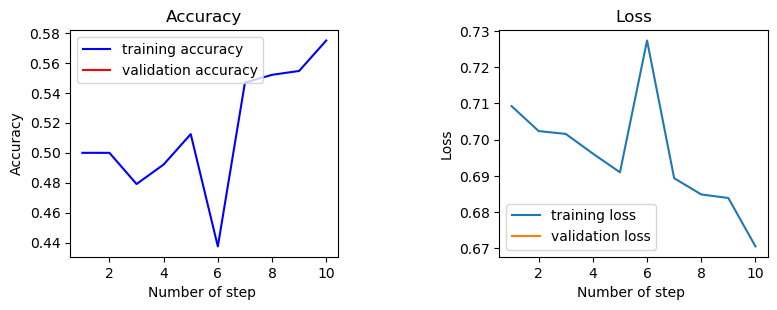

In [53]:
mm.plot_acc_loss(steps_loss_train=histories_per_step.steps, loss_train=histories_per_step.losses,
                 steps_acc_train=histories_per_step.steps, accuracy_train=histories_per_step.accuracies,
                 steps_loss_eval=histories_per_step.val_steps, loss_eval=histories_per_step.val_losses,
                 steps_acc_eval=histories_per_step.val_steps, accuracy_eval=histories_per_step.val_accuracies)

### Visualization using TenorBoard callback

In [54]:
history_train=mu.load_data_tensorboard(log_dir+'/train')
history_val=mu.load_data_tensorboard(log_dir+'/validation')
debug=False


if debug:
    print('\n')
    for file in glob.glob(log_dir+'/train/*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print('\nnumber of entry for train:', len(history_train['batch_loss'][0]))
    print('\n',history_train)
    print('\nnumber of entry for eval:', len(history_train['epoch_loss'][0]))
    print('\n',history_val)
    print('\n\n\n')

Loss:
  - loss [training dataset]: 0.671
  - loss [validation dataset: 0.682

Accuracy:
  - accuracy [training dataset]: 57.50%
  - accuracy [validation dataset: 52.60%


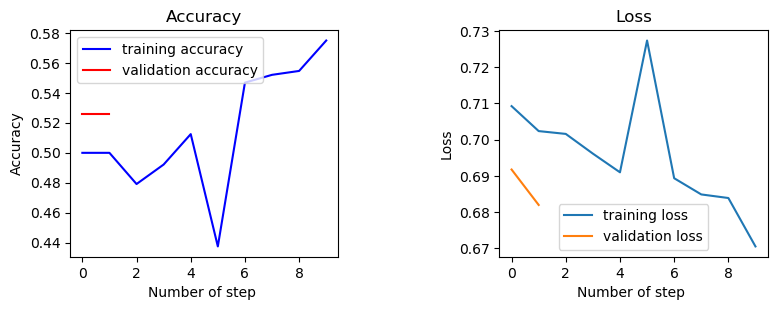

In [55]:
mm.plot_acc_loss(steps_loss_train=history_train['batch_loss'][0], loss_train=history_train['batch_loss'][1],
                 steps_acc_train=history_train['batch_accuracy'][0], accuracy_train=history_train['batch_accuracy'][1],
                 steps_loss_eval=history_val['epoch_loss'][0], loss_eval=history_val['epoch_loss'][1],
                 steps_acc_eval=history_val['epoch_accuracy'][0], accuracy_eval=history_val['epoch_accuracy'][1])

### Metadata

In [56]:
print(model.metrics)
print(model.metrics_names)

[<tensorflow.python.keras.metrics.Mean object at 0x1a45c10f90>, <tensorflow.python.keras.metrics.SparseCategoricalAccuracy object at 0x1a3f7a1690>]
['loss', 'accuracy']


In [57]:
history.epoch

[0, 1]

In [58]:
history.params

{'verbose': 1, 'epochs': 2, 'steps': 5}

In [59]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [60]:
# dir(history)

### Exploration of the model's structure

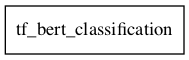

In [61]:
tf.keras.utils.plot_model(model,
                          'model.png',
                          show_shapes=True)

In [62]:
model.inputs

In [63]:
model.outputs

In [64]:
model.layers

In [65]:
# _inbound_nodes and inbound_nodes give the same !
# to see method available: dir(model.layers[2])
for layer in model.layers:
    print(layer.name, layer._inbound_nodes, layer._outbound_nodes)

bert [] []
dropout_37 [] []
classifier [] []


## Model's evaluation and validation

### Making prediction

In [66]:
# get probablility for each classes
if model.name=='custom_tf_bert_classification':
        print('custom model: {}'.format(model.name))
        y_pred = tf.nn.softmax(model.predict(valid_dataset))
elif model.name=='tf_bert_classification':
        print('standard model: {}'.format(model.name))
        y_pred = tf.squeeze(tf.nn.softmax(model.predict(valid_dataset)))

standard model: tf_bert_classification


In [67]:
y_pred.shape

TensorShape([872, 2])

In [68]:
# get predicted classes
y_pred_argmax = tf.math.argmax(y_pred, axis=1)        

In [69]:
(y_pred_argmax).shape

TensorShape([872])

### Extracting true classes

In [70]:
# extracting and flatten true classes
y_true_tf=valid_dataset.map(pp.label_extraction).flat_map(lambda x: valid_dataset.from_tensor_slices(x))

In [71]:
y_true=list(y_true_tf.as_numpy_iterator())

In [72]:
len(y_true), len(y_pred_argmax)

(872, 872)

### Model performanes

In [73]:
print(classification_report(y_true, y_pred_argmax, target_names=info.features["label"].names))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       428
    positive       0.51      1.00      0.67       444

    accuracy                           0.51       872
   macro avg       0.25      0.50      0.34       872
weighted avg       0.26      0.51      0.34       872



/Users/tarrade/anaconda-release/conda-env/env_test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
mm.print_metrics(y_true, y_pred_argmax, mode='')

Model performance on the  dataset:
   Metric             
accuracy...........   0.5092
recall.............   1.0000
auc................   0.5000
precision (p=0.5)..   0.5092
precision (avg)....   0.5092
precision (micro)..   0.5092
precision (macro)..   0.2546
f1.................    0.6748
r2.................   -0.9640


/Users/tarrade/anaconda-release/conda-env/env_test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Confusion matrix

In [75]:
plt.rcParams['figure.figsize'] = [10, 7]

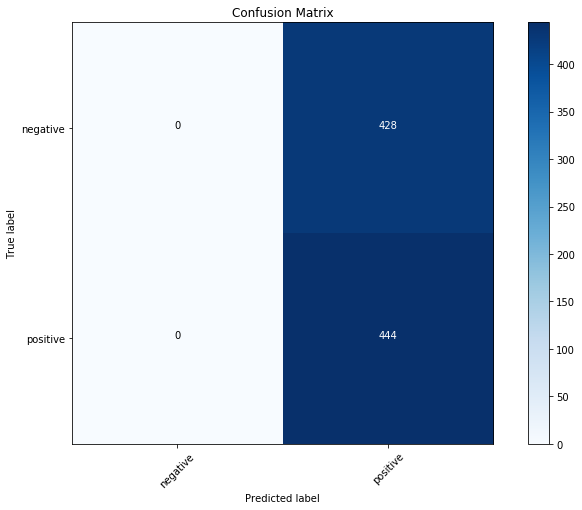

In [76]:
mm.plot_confusion_matrix(confusion_matrix(y_true, y_pred_argmax), info.features["label"].names)

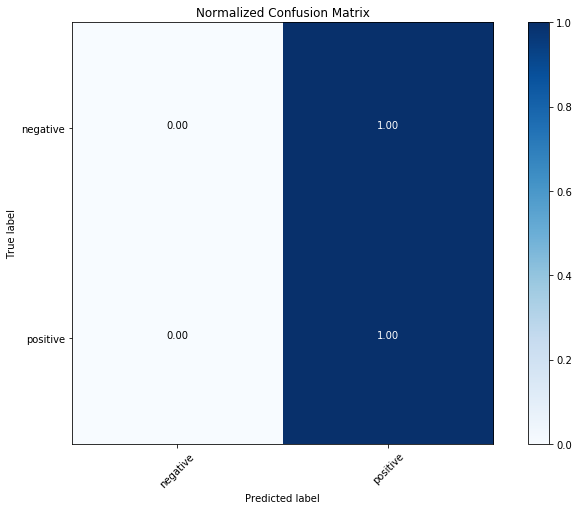

In [77]:
mm.plot_confusion_matrix(confusion_matrix(y_true, y_pred_argmax), info.features["label"].names, normalize=True)

### ROC curves

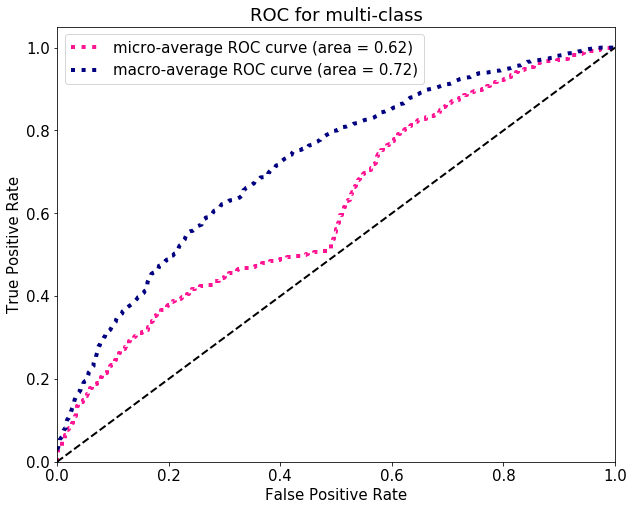

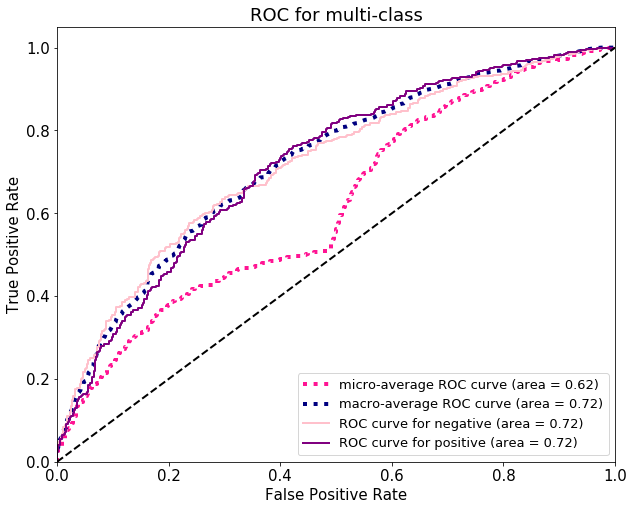

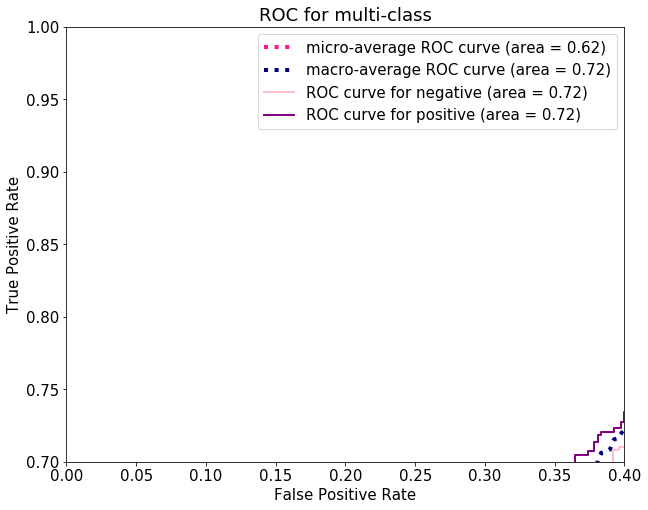

In [78]:
mm.roc_curves(to_categorical(y_true), y_pred.numpy(), info.features["label"].names)

## Model's inference

In [79]:
# getting a random example from the test data
for i in data['test'].shuffle(100).take(1):
    print('sentence: {}\nlabel:    {}'.format(i['sentence'].numpy().decode(), info.features["label"].names[i['label'].numpy()]))

sentence: it is a comedy that 's not very funny and an action movie that is not very thrilling ( and an uneasy alliance , at that ) .
label:    positive


In [80]:
# translate some example in some languages
text = ["Zhang Yimou livre des personnages chaleureux et authentiques qui mentent non par malhonnêteté, mais parce qu'ils croient sincèrement que c'est la seule façon d'apporter le bonheur à leurs proches."]

In [81]:
def made_prediction(text):
    print('example of input:\n\n{}\n \nlength:{}\n'.format(text[0], len(text)))
    #print('text:{} length:{}\n'.format(text, len(text)))
    # get probablility for each classes
    tokens=tokenizer.batch_encode_plus(text, return_tensors="tf",  pad_to_max_length=True)
    digits=model.predict(tokens)
    if model.name=='custom_tf_bert_classification':
        print('custom model: {}'.format(model.name))
        y_single_pred = tf.nn.softmax(digits)
    elif model.name=='tf_bert_classification':
        print('standard model: {}'.format(model.name))
        temp=tf.nn.softmax(digits)
        y_single_pred = tf.squeeze(temp)
        return y_single_pred.numpy()

In [82]:
y_single_pred=made_prediction(text)

example of input:

Zhang Yimou livre des personnages chaleureux et authentiques qui mentent non par malhonnêteté, mais parce qu'ils croient sincèrement que c'est la seule façon d'apporter le bonheur à leurs proches.
 
length:1

standard model: tf_bert_classification


In [83]:
y_single_pred

array([0.43226552, 0.56773454], dtype=float32)

In [84]:
info.features["label"].names[tf.math.argmax(y_single_pred).numpy()]

'positive'

### Model interpretation

In [85]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=info.features["label"].names)

In [86]:
# will do 5'000 permutations/selections of the original sentence and made prediction
exp = explainer.explain_instance(text[0], made_prediction, num_features=6)

example of input:

Zhang Yimou livre des personnages chaleureux et authentiques qui mentent non par malhonnêteté, mais parce qu'ils croient sincèrement que c'est la seule façon d'apporter le bonheur à leurs proches.
 
length:5000

standard model: tf_bert_classification


In [87]:
exp.as_list()

[('livre', -0.0050967079746947865),
 ('des', -0.004424862151228278),
 ('Zhang', -0.004408324213531526),
 ('qui', 0.004163360874286789),
 ('personnages', 0.003846985463782681),
 ('bonheur', 0.003626344948140689)]

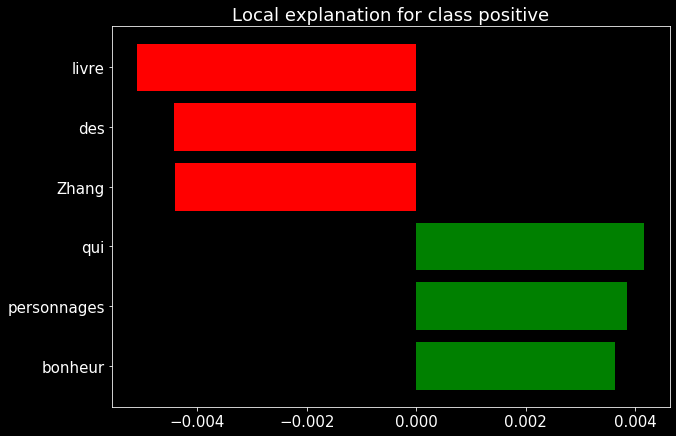

In [88]:
plt.style.use('dark_background')
fig = exp.as_pyplot_figure()

In [89]:
exp.show_in_notebook(text=True)

In [90]:
exp.save_to_file('ex.html')

In [91]:
from IPython.display import IFrame    
IFrame(src="ex.html", width=900, height=350)

In [92]:
from IPython.core.display import display, HTML
display(HTML('<iframe src=ex.html width=900 style="background: #FFFFFF;" height=350></iframe>'))

/Users/tarrade/anaconda-release/conda-env/env_test/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Copy the model on GCP

The variables directory contains a standard training checkpoint (see the guide to training checkpoints).  
The assets directory contains files used by the TensorFlow graph, for example text files used to initialize vocabulary tables.
The saved_model.pb file stores the actual TensorFlow program, or model, and a set of named signatures, each identifying a function that accepts tensor inputs and produces tensor outputs.

SavedModels may contain multiple variants of the model (multiple v1.MetaGraphDefs, identified with the --tag_set flag to saved_model_cli), but this is rare. APIs which create multiple variants of a model include 

In [93]:
def copy_local_directory_to_gcs(local_path, bucket, gcs_path):
    """Recursively copy a directory of files to GCS.

    local_path should be a directory and not have a trailing slash.
    """
    assert os.path.isdir(local_path)
    for root, dirs, files in os.walk(local_path):
        for name in files:
            local_file = os.path.join(root, name)
            remote_path = os.path.join(gcs_path, local_file[1 + len(local_path) :])
            print(remote_path)
            blob = bucket.blob(remote_path)
            blob.upload_from_filename(local_file)
            print('copy of the file on gs:// done !')

In [94]:
storage_client = storage.Client()
bucket = storage_client.get_bucket(os.environ['BUCKET_NAME'])

/Users/tarrade/anaconda-release/conda-env/env_test/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/tarrade/anaconda-release/conda-env/env_test/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information ab

In [95]:
source_bucket_name = savemodel_path+'/'+model.name
destination_bucket_name = 'saved_model/tf_bert_classification'

In [96]:
copy_local_directory_to_gcs(source_bucket_name, bucket, destination_bucket_name)

saved_model/tf_bert_classification/history
copy of the file on gs:// done !
saved_model/tf_bert_classification/history_per_step
copy of the file on gs:// done !
saved_model/tf_bert_classification/saved_model.pb
copy of the file on gs:// done !
saved_model/tf_bert_classification/variables/variables.data-00000-of-00001
copy of the file on gs:// done !
saved_model/tf_bert_classification/variables/variables.index
copy of the file on gs:// done !


In [97]:
for root, dirs, files in os.walk(source_bucket_name):
    for name in files:
        print(os.path.join(root, name))

/Users/tarrade/tensorflow_checkpoints/saved_model/tf_bert_classification/history
/Users/tarrade/tensorflow_checkpoints/saved_model/tf_bert_classification/history_per_step
/Users/tarrade/tensorflow_checkpoints/saved_model/tf_bert_classification/saved_model.pb
/Users/tarrade/tensorflow_checkpoints/saved_model/tf_bert_classification/variables/variables.data-00000-of-00001
/Users/tarrade/tensorflow_checkpoints/saved_model/tf_bert_classification/variables/variables.index


### Online Predictions

#### Defined a name for our model on GCP and create it

In [98]:
# defining the name of the model for online prediction
os.environ['MODEL_NAME']=model.name+'_test'

In [99]:
# Normal VM has a model size of 500 MB for more you need to use a specific n1-standard-2 VM (2 GB) for online prediction. It is only available in us-central1.
os.environ['REGION_PRED']='us-central1'

In [100]:
%%bash
gcloud ai-platform models create $MODEL_NAME \
       --regions=$REGION_PRED \
       --enable-logging

ERROR: (gcloud.ai-platform.models.create) Resource in project [axarevvicnonprod] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


CalledProcessError: Command 'b'gcloud ai-platform models create $MODEL_NAME \\\n       --regions=$REGION_PRED \\\n       --enable-logging\n'' returned non-zero exit status 1.

#### Defined parameters and upload our models

In [ ]:
# define python and run time version
os.environ['RUNTIME_VERSION'] = '2.1'
os.environ['PYTHON_VERSION'] = '3.7'
os.environ['MODEL_BINARIES'] = 'gs://'+os.environ['BUCKET_NAME']+'/saved_model/'+model.name
os.environ['MODEL_VERSION'] = 'v1'

In [ ]:
%%bash
gcloud beta ai-platform versions create $MODEL_VERSION \
       --model $MODEL_NAME \
       --origin $MODEL_BINARIES \
       --runtime-version $RUNTIME_VERSION \
       --python-version $PYTHON_VERSION \
       --machine-type n1-standard-2 \
       --description "This is sentiment classifier using BERT and fine tune on SST-2 for test"

#### Check models already deployed

In [ ]:
%%bash
gcloud ai-platform models list

#### Prepare data for online prediction

In [ ]:
# example of format:

```--json-request  
  {  
    "instances": [  
      {"x": [1, 2], "y": [3, 4]},  
      {"x": [-1, -2], "y": [-3, -4]}  
    ]  
  }  ```
  
```--json-instances  
  {"images": [0.0, …, 0.1], "key": 3}  
  {"images": [0.0, …, 0.1], "key": 2}  ```

In [ ]:
np_array = np.array(list(valid_dataset.unbatch().as_numpy_iterator()))

In [ ]:
np_array.shape

In [ ]:
import codecs
import json
json_file = "input_predict_gcloud.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    for el in np_array[0:2]:
        #print(el[0]['input_ids'])
        #print(el[0]['input_ids'].shape, el[0]['input_ids'].dtype)
        #print(el[0]['attention_mask'].shape, el[0]['attention_mask'].dtype)
        #print(el[0]['token_type_ids'].shape, el[0]['token_type_ids'].dtype)
        instance={'input_ids': el[0]['input_ids'].tolist(), 'attention_mask': el[0]['attention_mask'].tolist(), 'token_type_ids': el[0]['token_type_ids'].tolist()}
        json.dump(instance, f , sort_keys=True)
        f.write("\n")

In [ ]:
# how to look at these data ?

In [ ]:
with open('input_predict_gcloud.json') as json_file:
    for i in json_file:
        # convert string to dictionary
        json_data = eval(i)
        print(json_data.keys())
        print(json_data)

#### Make local prediction to test the model and input data

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda-release/conda-env/env_gcp_sdk/bin/python'
os.environ['CLOUDSDK_GSUTIL_PYTHON']='/Users/tarrade/anaconda-release/conda-env/env_gcp_sdk/bin/python'

In [ ]:
os.environ['MODEL_LOCAL']=savemodel_path+'/'+model.name

In [ ]:
%%bash
saved_model_cli show --dir $MODEL_LOCAL --tag_set serve 

In [ ]:
%%bash
saved_model_cli show --dir $MODEL_LOCAL --tag_set serve --signature_def serving_default

In [ ]:
%%bash
gcloud ai-platform local predict \
       --signature-name serving_default \
       --model-dir $MODEL_LOCAL \
       --json-instances input_predict_gcloud.json \
       --verbosity info \
       #--log-http 

#### Make online prediction

In [ ]:
%%bash
gcloud ai-platform predict \
       --model $MODEL_NAME \
       --version $MODEL_VERSION \
       --json-instances input_predict_gcloud.json\
       --verbosity info \
       #--log-http

# Data analysis

In [ ]:
def extraction(feature):
    print('feature:',feature['sentence'])
    
    return feature['sentence'], feature['label']

In [ ]:
for i in a:
    print(i[0].numpy())
    break

In [ ]:
np_array = np.array(list(data['train'].map(extraction).as_numpy_iterator()))

In [ ]:
np_array.shape

In [ ]:
import pandas as pd
df = pd.DataFrame(data=np_array, columns=['sentence', 'label'])

In [ ]:
df['text']=df['sentence'].apply(lambda x: x.decode("utf-8"))

In [ ]:
df['label']=df['label'].astype('int32')

In [ ]:
df.columns

In [ ]:
df.pop('sentence')

In [ ]:
df

In [ ]:
df.isnull().sum()

In [ ]:
len(df)

In [ ]:
df.dtypes

In [ ]:
df['label'].value_counts(dropna=False)

In [ ]:
df['word_count'] = df['text'].apply(lambda txt: len(txt.split(' ')))

In [ ]:
df.head()

In [ ]:
import seaborn as sns
q=0.95
x = df['word_count']
sns.distplot(x, hist=True, rug=True);
print('Minimum word count required to include all words in {}% of the reviews: {}'.format(q*100, x.quantile(q)))

In [ ]:
df['word_count'].describe()


In [ ]:
kwargs = {'cumulative': True}
sns.distplot(x, hist_kws=kwargs);

In [ ]:
tot=len(df)
for size in [2, 5, 10, 20, 27]:
    nb=len(df[df['word_count'] <size])
    print('thresold: {:10d}  amount of data selected: {:10d} percentage of the data selected: {:.2f} %'.format(size, nb , nb/tot*100))